# Layerwise_mi_figures

/tmp/ipykernel_34/3156222434.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  line_colour = plt.cm.get_cmap('tab10')


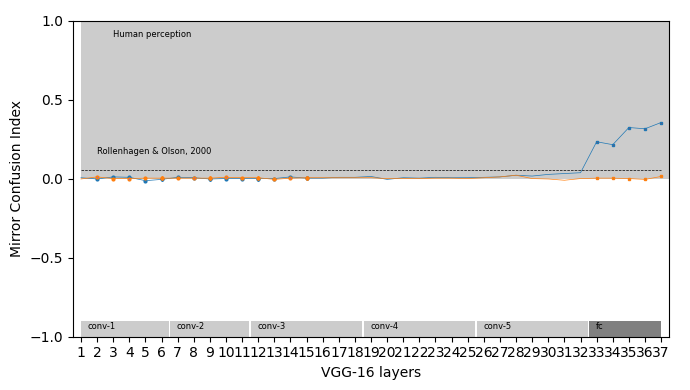

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


def layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi=None, reference_name=None, legend_name=None,
                         y_label=None, shaded_region_name='Human perception', y_limits=None):
    if y_limits is None:
        y_limits = [-1, 1]

    plt.figure(figsize=(7, 4))

    # Drawing the human perception rectangle
    plt.gca().add_patch(Rectangle((1, 0), 37, 1, facecolor=[0.8, 0.8, 0.8], edgecolor='none'))

    # Naming the layers by drawing the bottom rectangles
    layer_grouping = np.array([[1, 6.45], [6.55, 11.45], [11.55, 18.45], [18.55, 25.45], [25.55, 32.45], [32.55, 37]])
    layer_colour = np.vstack([np.tile([0.8, 0.8, 0.8], (5, 1)), [0.5, 0.5, 0.5]])
    box_width = 0.2 / (y_limits[1] - y_limits[0])

    for ind, (start, end) in enumerate(layer_grouping):
        plt.gca().add_patch(
            Rectangle((start, y_limits[0]), end - start, box_width, facecolor=layer_colour[ind], edgecolor='none'))
        plt.text(start + 0.4, y_limits[0] + box_width / 2, ['conv-1', 'conv-2', 'conv-3', 'conv-4', 'conv-5', 'fc'][ind], color='k', fontsize=6)

    # Plotting the data
    line_colour = plt.cm.get_cmap('tab10')
    marker_size = 2
    layer_ind = np.arange(1, 38)
    # print(mean_data)
    # print(np.array(mean_data).shape)
    mean_data = np.array(mean_data)
    for ind in range(mean_data.shape[0]):
        if sem_data is not None and not np.all(np.isnan(sem_data)):
            shadedErrorBar(layer_ind, mean_data[ind], sem_data[ind], lineprops=['-', {'markerfacecolor': line_colour(ind), 'color': line_colour(ind), 'linewidth': 0.5}], transparent=True, patchSaturation=0.3)
        else:
            plt.plot(layer_ind, mean_data[ind], '-', markerfacecolor=line_colour(ind), color=line_colour(ind), linewidth=0.5)

        plt.plot(layer_ind[1:14:2], mean_data[ind, 1:14:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind))
        plt.plot(layer_ind[2:15:2], mean_data[ind, 2:15:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[5:16:3], mean_data[ind, 5:16:3], 'd', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[32:], mean_data[ind, 32:], 's', markersize=marker_size, markeredgecolor=line_colour(ind))

    # Visual search modulation index
    if reference_mi is not None:
        if isinstance(reference_mi, (list, np.ndarray)):
            for i, mi in enumerate(reference_mi):
                plt.plot([1, 37], [mi, mi], '--', color='k', linewidth=0.5)
                plt.text(2, mi + 0.1, reference_name[i], fontsize=6)
        else:
            plt.plot([1, 37], [reference_mi, reference_mi], '--', color='k', linewidth=0.5)
            plt.text(2, reference_mi + 0.1, reference_name, fontsize=6)

    # Naming the shaded region
    plt.text(3, 0.9, shaded_region_name, fontsize=6)

    plt.xlim(0.5, 37.5)
    plt.ylim(y_limits)
    plt.xticks(range(1, 38))
    plt.yticks(np.linspace(y_limits[0], y_limits[1], 5))

    plt.xlabel('VGG-16 layers')
    plt.ylabel(y_label)

    if legend_name is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, fontsize=6, loc='best', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()

# vl_simplenn

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def vl_simplenn(net, x, res=None):

    n=len(net.features) + len(net.classifier)
    if (res is None):
        res = [{'x': None} for _ in range(n + 1)]

    res[0]['x'] = x
    i=0
    for (name, layer) in net.named_children():
        for  (sub_name, sub_layer) in (layer.named_children()):
            ltype=sub_layer.__class__.__name__

            if ltype == 'Conv2d':
                res[i + 1]['x'] = F.conv2d(res[i]['x'], sub_layer.weight,sub_layer.bias,
                            padding=sub_layer.padding, stride=sub_layer.stride, dilation=sub_layer.dilation)

            elif ltype == 'MaxPool2d':
                res[i + 1]['x'] = F.max_pool2d(res[i]['x'],
                            padding=sub_layer.padding, stride=sub_layer.stride,kernel_size=sub_layer.kernel_size)
            elif ltype=='Linear':
                linear_layer = nn.Linear(res[i]['x'].flatten().shape[0], 4096)
                output_tensor = linear_layer(res[i]['x'].flatten())
                res[i + 1]['x'] = output_tensor.to(torch.float32)
#                 temp= nn.Linear(res[i]['x'].flatten().shape[0], 4096)
#                 res[i + 1]['x'] = torch.tensor(temp),dtype=torch.float32
            elif ltype=='Dropout':
                i=i-1
#                 dropout_layer = CustomDropout(p=0.5)
#                 print(dropout_layer)
#                 res[i + 1]['x'] = dropout_layer
            elif ltype== 'ReLU':
                # if l['leak'] > 0:
                #     leak = {'leak': l['leak']}
                # else:
                leak = {}

                if res[i]['x'] is not None:
                    res[i + 1]['x'] = F.relu(res[i]['x'], **leak)
                else:
                    res[i + 1]['x'] = F.relu(res[i + 1]['x'], **leak)
            i+=1
    return res

# Extract_features

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np

def extract_features(net, stim, type, dagg_flag, run_path):
    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # Extract the image data from the loaded dictionary
    stim_images = stim
    nimages = len(stim_images[0][0])
    print(stim_images[0][0])
    if dagg_flag==0:
        features = []
        for ind in range(nimages):
            # Convert the numpy array to PIL Image
            image_array = stim_images[0][0][ind]
            if len(image_array.shape) < 3:
                image_array = np.stack((image_array,) * 3, axis=-1)
            image = Image.fromarray(image_array)

        # Preprocess and normalize the image
            image_tensor = preprocess(image)
            
            features.append(vl_simplenn(net, image_tensor))
        return features
# Main Code Directory location and SLASH of the OS
def check_mirror_confusion(stim, net_type, dagg_flag, run_path):
    # Here I assume the Stimuli is arranged in a particular order
    # 100 unique stimuli, followed by 100 mirror about y-axis, followed by 100 mirror about x-axis
    N = 5  # There are 100 unique stimuli
    mirror_confusion_index = np.zeros((N, 37))

    for img in range(N):
        img_numbers = [img, N + img, 2 * N + img]
        stim_sub = [stim[i] for i in img_numbers]
        features= extract_features(net_type, stim_sub, net_type, dagg_flag, run_path)
        nL = len(features[0]) - 1
        for L in range(nL):
            fi = features[0][L]['x'].squeeze().detach().numpy()
            fYm = features[1][L]['x'].squeeze().detach().numpy()
            fXm = features[2][L]['x'].squeeze().detach().numpy()
            dYm = np.linalg.norm(fYm.flatten() - fi.flatten(), ord=2)  # MIRROR ABOUT X-axis
            dXm = np.linalg.norm(fXm.flatten() - fi.flatten(), ord=2)  # MIRROR ABOUT Y-axis
            mirror_confusion_index[img, L] = (dXm - dYm) / (dXm + dYm)

    return mirror_confusion_index
# STIM
all_models = []
stim_file_name = '/kaggle/input/mirror-confusion-stim/natural_stim_50_rotated_90.mat'
stim = sio.loadmat(stim_file_name)['stim'][:13]
types = vgg16(pretrained=True)
all_models.append(types)

# print(stim)
# Reference
reference_mi = (16.075 - 14.33) / (16.075 + 14.33)
reference_name = 'Rollenhagen & Olson, 2000'

for k, net_type in enumerate(all_models):
#     tstart = time.time()
    print('\n Network- %s \n' % net_type)

    print('\n Extracting Features and Calculating Mirror Confusion \n')
    mirror_confusion_index = check_mirror_confusion(stim, net_type, 0, run_path)
    mi_mean = np.nanmean(mirror_confusion_index, axis=0)
    mi_sem = np.nanstd(mirror_confusion_index, axis=0) / np.sqrt(np.sum(~np.isnan(mirror_confusion_index), axis=0))

    # Plotting
    dist_types = 'Euclidean'
    y_label = 'Mirror Confusion Index'
    if iter <= 3:  # Layer-wise plot for VGG-Network
        layerwise_mi_figures(mi_mean, mi_sem, saving_file_name, reference_mi, reference_name, dist_types, y_label)
    else:  # Layer-wise plot for other networks
        layerwise_mi_nonVGGfigures(mi_mean, mi_sem, saving_file_name, reference_mi, reference_name, dist_types, y_label)
    time_taken[iter] = time.time() - tstart

# PLotting the effect for three networks
sel_index = [0, 2]  # Adjust indices accordingly
mean_data = np.zeros((len(sel_index), 37))
sem_data = np.zeros((len(sel_index), 37))
for ind, sel in enumerate(sel_index):
    mean_data[ind, :] = mi_mean
    sem_data[ind, :] = mi_sem
layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi, reference_name, [network_short_name[i] for i in sel_index], 'Mirror Confusion Index')

# Plotting the effect for starting point during training
sel_index = [0, 1]  # Adjust indices accordingly
mean_data = np.zeros((len(sel_index), 37))
sem_data = np.zeros((len(sel_index), 37))
for ind, sel in enumerate(sel_index):
    mean_data[ind, :] = mi_mean
    sem_data[ind, :] = mi_sem
layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi, reference_name, [network_short_name[i] for i in sel_index], 'Mirror Confusion Index')



 Network- VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0,